# Generalised linear models (GLMs) of neural responses

In this lesson, the goals are to learn...

1. What are GLMs
2. How are they used to model the response of single neurons to different stimuli
3. What is the difference between a linear and a non-linear activation function 
4. How can Poissonian activation be used to model important features of neural responses.

### <font color='teal'> Introduction </font>

In this lesson, you will learn how to model the response of a neuron as a function of an external stimulus using **Generalized linear models (GLM)**

This concept will be particularly useful in the study of early sensory processes, where the activity of single neurons can be well characterized as an **input-output function**. That is, *taking a sensory stimulus* (eg.: pattern of photons hitting the retina, mechanical vibrations perceived as sound,...) and *producing a pattern of activity*

This phenomena can be studied with many different tools such as tunning curves. In this lesson, we will focus on one such method that are the GLMs, a class of simple but powerful models that can be used to describe how the firing rate of a neuron depends on the (value) of the sensory input.

### <font color='teal'> Stimulus-response functions </font>

A major challenge in characterising neural responses to sensory stimuli is that the possible space of inputs is very large and potentially infinite. An example from the auditory field might help illustrate this problem.

Imagine that you have a piano with 88 keys and you wish to understand how a neuron in the audiroty cortex is processing sounds. All sensory neurons are more or less non-linear. As such, the neural response to the combination of keys C1 and E1 is not the same as the sum of C1 and E1 presented alone 

$$response(C1/E1) \neq response(C1) + response(E1)$$

As a consequence, probing the neuron with all possible key combinations would require $2^88 - 1$ stimuli. Even if we fix the duration of each stimulus to 1 second and use the same sound level, this would still exceed the lifetime of any species used for studying these principles in the laboratory.

We need a smater approach.

### <font color='teal'> GENERALIZED LINEAR MODELS</font>

An alternative approach is to use a statistical model that seeks to characterize a response to complex stimuli. This allows us to restrict the shape that the neural response can take to a much smaller hypothesis space, using some assumptions on the kind of function that the neuron implements.

GLMs are a powerful set of such statistical models which hypothesizes that the neural responses are a result of two stages: a **linear filter of the input** and a **static non-linearity**

#### <font color='indianred'> 1. Linear stage </font>

The linear stage consists of one or more linear filters represented by the vectors $\bm{k}_1, \bm{k}_2,...$ that describes how a neuron is integrating stimulus features. In this lesson, we will focus on models with a single filter $\bm{k}$.

The linear filters are linked to the concept of a **receptive filed (RF)** and indeed both terms are used interchangeably. Broadly speaking, the RF is a portion of the sensory space that can elicit neuronal responses when stimulated. For a visual neuron, the sensory space is typically 2- or 3- dimensional. 

Often, the precise geometry of the sensory space isn't relevant. Instead, we treat every 'element' (eg.: a pixel of an image) of the sensory space as a single dimension of a high-dimensional feature space such that we can write the stimulus as a vector 

$$\bm{s} = (s_1, s_2, ..., s_D)^T$$

The **output of the linear stage** is simply the dot product between the linear filter and the stimulus

$$x = \bm{k}^T s = \sum_{i=1}^D k_is_i$$

Thus,  *the entries of the vector $\bm{k}$ can be interpreted as the weights that a neuron gives to different stimulus features*. For a visual neuron, the weights would be non-zero for pixel in its receptive field and zero otherwise. 

It is exactly this **simple interpretation of model parameters in the original stimulus space** that makes GLMs so appealing.

#### <font color='teal'> LINEAR GAUSSIAN MODELS</font>
---

In the simplest case, the neuron's response is assumed to be modeled directly by the output of a single filter, possibly with a constant offset response

$$r_t = \bm{k}^T\bm{s}_t + r_0 + \mathcal{N}(0, \sigma^2)$$

where response variability is Gaussian distributed with constant variance ($\sigma^2$) around the output filter. The **constant offset $r_0$** can be conveniently absorbed into the RF vector $\bm{k}$ by setting an additional dimension in the stimulus vector $\bm{s}_t$ to 1 at all times, such that the offset becomes the coefficient associated with this added dimension. Then, we'll typically omit explicit reference to the offset term.

Given a stimulus and a measured response, the **estimated filter weights $\hat{\bm{k}}$** can be obtained by minimizing the squared difference between the model output and the measured data:

$$\hat{\bm{k}} = \argmin_k \sum_{t=1}^N || r_t - \bm{k}^T\bm{s}_t||^2 = (S^TS)^{-1}S^Tr$$

In the latter, $S$ is the **stimulus design matrix** where each row corresponds to a stimulus vector at time step $t$ ($\bm{s}_1,\bm{s}_2,...,\bm{s}_N$) and $\bm{r}$ is a column vector of the corresponding measured responses. 

The matrix product $S^Tr$ gives the sum of all stimuli that evoked spikes and if divided by the total number of spikes, this would be the **spike-triggered average (STA)** stimulus. 

As for the term $S^TS$, it corresponds to the **stimulus auto-correlation matrix** that if pre-multiplied by its inverse removes any structure in the STA that might arise from correlations between different stimulus inputs, leaving an estimate of the RF filter.

More generally, the above equations correspond to the maximum likelihood estimator (MLE) for a model on which response variability is Gaussian distributed with constant variance around the filter output $x_t$. That is, minizing the least squares is the same as finding the MLE.

#### <font color='indianred'> 2. Nonlinear stage </font>

In the nonlinear stage, the linearly filtered stimulus $x$ is transformed into a spike rate using a static, memoryless nonlinearity $f$. The **output of the nonlinear stage** for a singles filter is 

$$f(\bm{k}^T s)$$

For dynamically fluctuating stimuli, the time-varying output can be simply described by $f(\bm{k}^T s_t)$ where $s_t$ is the stimulus at a discrete time step $t$.

The **type of nonlinearity** used in this stage defines the specific kind of GLM. For this lecture, we'll discuss the **linear Gaussian** models and the **non-linear Poisson** model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

Let's see the gaussian linear model in action. We will generate some data by modeling the response of a neuron to a sequence of visual stimuli. We will model the visual field as a 2D matrix of a certain size in terms of the number of pixels. Our stimulus will consist of gaussian noise, spread around the visual field and presented for 10 seconds at a rate of 10 Hz.

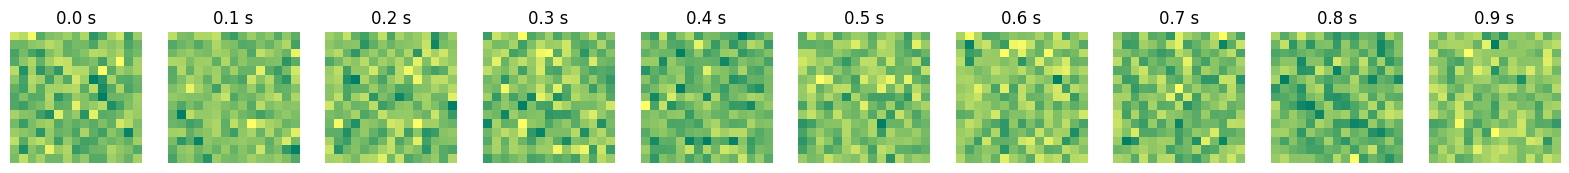

In [2]:
duration = 50
dt = 0.1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / dt)

# Design matrix
S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])

# Plot of the first second of stimuli
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(S[i], cmap='summer')
    plt.axis('off')
    plt.title('0.{} s'.format(i))

Then, we create the receptive field of the neuron. The code below creates a Gabor filter/patch. It is defined by a sinusoidal wave multiplied by a gaussian function and it is often used to study the selectivity of cells in the early visual cortex. **The receptive field of the neuron is modeled as a Gabor filter**

Text(0, 0.5, 'y')

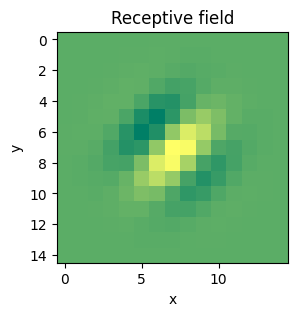

In [3]:
# Gabor filter parameters
size = vf_size            # Size of the receptive field (in pixels)
mu = (8,8)                # Center of the Gabor patch
sigma = (4,4)             # Size of the Gabor patch
angle = 45                # Orientation of the Gabor patch
frequency = 0.085         # Spatial frequency of the Gabor patch
phase = 0                 # Phase of the Gabor patch

xx, yy = np.meshgrid(1 + np.arange(size[0]), 1 + np.arange(size[1]))

# Gaussian envelope
G = np.exp( -(xx - mu[0])**2 / (2 * sigma[0]) - (yy - mu[1])**2 / (2 * sigma[1]))

# Spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * (2 * np.pi) * 2 * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.max(np.abs(K))

plt.figure(figsize=(3,3))
plt.imshow(K, cmap='summer')
plt.title('Receptive field')
plt.xlabel('x')
plt.ylabel('y')

By building our receptive field in this way, we are forcing the assumption that this cell will be maximally responsive to visual stimuli that have a certain orientation (`angle`), a certain spatial frequency (`frequency`) and that are localized around a point in the visual field (`mu`). Let's now generate the neural responses using a gaussian linear function!

In [4]:
noise_variance = 1    # For N(0,σ^2)
r0 = offset = 2  

# Flatten the matrices
K_flat = K.ravel()                   # [1 x 225]
K_flat = np.hstack((K.flat, offset)) # [1 x 226], adding the offset 

S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2]) # [500 x 225]
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))      # [500 x 226], i.e., add another column to account for the offset 

# Linear stage
ks = K_flat @ S_flat.T    # Expected response. [1 x 226].[226 x 500] = [1 x 500]

# Nonlinear stage. 
# For a linear model, the non-linearity is simply the identity

# Add Gaussian noise centered around the 'true' rate for each bin
rate = r = ks                   # Actual response
r = r + np.sqrt(noise_variance) * np.random.randn(n_bins)

*So far: we know the receptive field of the neuron and we konw what stimulus is being given to it at eact time instant. With these we can build the neuron's response.*

We can visualize the time course of the firing rate and of the input current. In this case, they will be the same apart from the added Gaussian noise we add to model the neuron's response $r$. Additionally, we can also plot the relantionship between the rate and input by plotting one against the other 

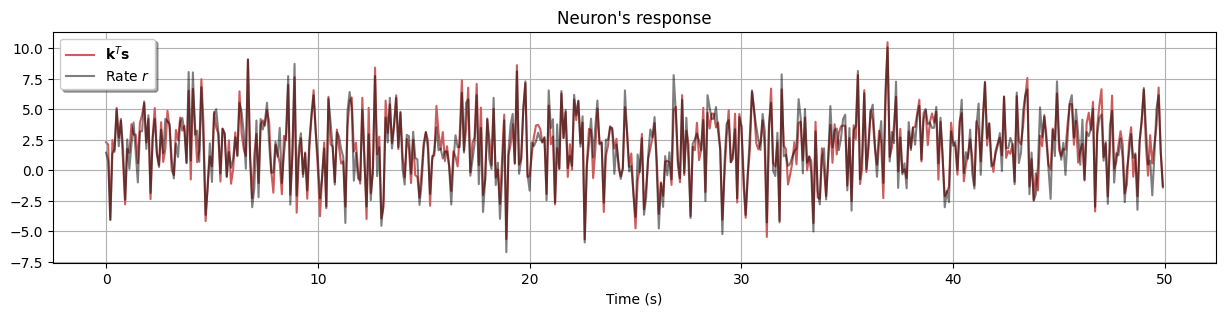

Text(0, 0.5, 'Rate $r$')

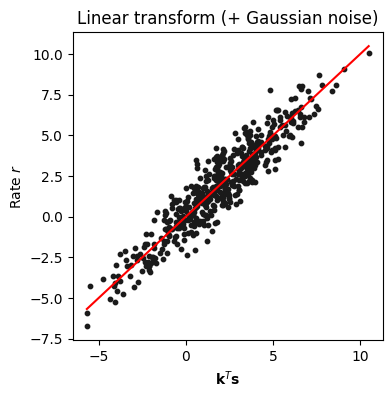

In [5]:
plt.figure(figsize=(15,3))
plt.title("Neuron's response")
t = np.arange(0, duration, dt)
plt.plot(t, ks, '-',color='indianred', label = r'$\mathbf{k}^T\mathbf{s}$')
plt.plot(t, r, '-', color='k', label = r'Rate $r$', alpha=0.5)
plt.legend(shadow=True)
plt.grid()
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(4,4))
plt.title('Linear transform (+ Gaussian noise)')
xx = np.linspace(ks.min(), ks.max(), 100)
plt.plot(xx, xx, 'r-')

plt.scatter(ks, r, s=10, c=[3*[.1]])

plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'Rate $r$')

**FITTING THE GLM**

We don't usually know what is the receptive field (vector $K$) of the neuron. In fact, most times we are tryong to reconstruct it from the neuron's response to a stimulus. That is, *we know the stimulus and we know the neuron's response. With these, we want to determine the neuron's receptive field/filter $K$*.

We can now apply the ordinary least squares procedure to estimate the parameters of the linear filter $K$ and compare its output to the true filter, i.e., the one we generated.

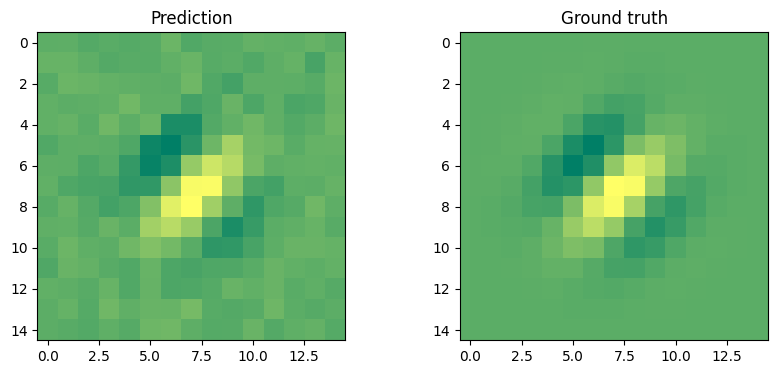

In [6]:
# Minimizing least squares difference <-> Maximum likelihood estimator
K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ r)
K_hat = K_hat[:-1].reshape(vf_size)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Prediction')
plt.imshow(K_hat, cmap='summer')

plt.subplot(1,2,2)
plt.title('Ground truth')
plt.imshow(K, cmap='summer')

We can reconstruct a neuron's receptive field with some accuracy. In the exercises, you will have the chance to explore how the quality of this estimation depends on the size and features of the data. 

The model we have just used is a simple linear one **(*)**, but the activity of neurons is highly nonlinear. A neuron only fires when its membrane potential reaches a certain threshold. In what follows, we will inclue this nonlinearity into the model.

**(*)** *In the non-linear stage we did nothing, that is, we applied the identity matrix, meaning that we only had the linear stage*

#### <font color='teal'> LINEAR-NONLINEAR POISSON MODELS</font>
---

For spike-train responses, a natural first assumption is that spike times are influenced only by the stimulus and are otherwise entirely independent of one another. This assumption requires that the distribution of spike times is governed by a **Poisson (point) process conditioned on the stimulus** and defined by an **instantaneous firing rate function** (aka, intensity function)

$$\lambda_t = f(\bm{k}^T\bm{s}_t)$$

In turn, this means that the distribution of counts within response time bins of size $\Delta$ must follow a Poisson distribution

$$P(r_t|\bm{s}_t,\bm{k}) = \frac{(\lambda_t\Delta)^{r_t}}{r_t!}e^{-\lambda_t\Delta} = \frac{[f(\bm{k}^T\bm{s}_t)\Delta]^{r_t}}{r_t!}e^{-f(\bm{k}^T\bm{s}_t)\Delta}$$

where $\lambda_t\Delta$ is the expected number of spikes in a small unit of time $\Delta$ and $\lambda_t$ is the rate (or intensity) of the Poisson process. If $f$ is assumed to be monotonic and fixed, rather then being defined by parameters that must be fit along with the RF, then the above equation describes an instance of a **generalized linear model (GLM)**. Many common choices of $f$ result in a likelihood which is a concave function, guarateeing the existence of a single optimum.

So... 

- Spike times are assumed to be independent of one another $\Rightarrow$ Spike time p.d.f. = Poisson p.d.f.
- Poisson p.d.f. is defined by instantaneous firing rate $\lambda = f(\bm{k}^T\bm{s}_t)$
- Poisson p.d.f. of spike times $\Rightarrow$ Spike count p.d.f within time bins is also a Poisson p.d.f.

**GENERATING DATA WITH A POISSON GLM**

Let's generate the spiking activity of a poisson neuron with a linear receptive field. We will use the same gaussian stimuli and the same linear filter $\bm{k}$ as before.

<font color='teal'> What will change is the static non-linearity of the second stage.</font> 

In [7]:
# Generation of the stimulus
duration = 100
dt = 0.1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / dt)

# Design matrix
S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])

# So far, the same as before!

Let's define a function to generate spikes given a firing rate $\lambda$ and a time interval $dt$ and then generate the data.

In [8]:
def generate_inhomogeneous_poisson_spike_times(lamba, dt):
    
    '''lambda: Firing rate function'''
    
    #n_bins = lamba.shape[0]
    n_bins = len(lamba)
    bins = np.arange(n_bins + 1) * dt

    # Generate Poisson distributed numbers for each of the bins
    # with the maximum rate/intensity/lambda    
    lamba_max = np.max(lamba)
    poisson_numbers = np.random.poisson(lamba_max, size = n_bins)

    # Throw away numbers depending on the actual intensity ('thinning')
    spike_times = []
    prob = lamba / lamba_max
    
    for i in range(n_bins):

        # Number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # Generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s) * dt
        
        spike_times.extend(ts)

    return np.asarray(spike_times)

In [9]:
# GENERATING DATA
spike_rate = 5          # Average firing rate

# Flatten the matrices
K_flat = K.ravel()
K_flat = np.hstack((K_flat, offset))

S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

# 1. Linear stage
ks = K_flat @ S_flat.T

# 2. Nonlinear stage
lamba = np.exp(ks)
# lamba -> rates -> r -> f(k^t.s)

# Lamba * dt is the number of spikes in the different bins. However, keep in mind
# that the Poisson process is a stochastic process so the actual number will differ
# each draw. Thus, the sum of the product across all bins gives the expected number
# of spikes for the whole draw

expected_rate = np.sum(lamba * dt) / duration
lamba *= (spike_rate / expected_rate)

# Generate spike times using an inhomogeneous poisson process
spike_times = generate_inhomogeneous_poisson_spike_times(lamba, dt)

# Compute the spike counts in the different time bins
spike_counts = np.histogram(spike_times,
                            bins = np.arange(n_bins + 1) * dt)[0]

print('Average spike rate: {} spikes per second'.format(len(spike_times)/duration))

Average spike rate: 4.69 spikes per second


*Again, for the linear-nonlinear Poisson model, we know the stimulus and we know the neuron's receptive filter/filter $K$. With those, we can compute the linear response which in turn is used to get the instantaneous firing rate function from the result of the nonlinear stage.*

*After, to visualize the neuron's response, we need to convert the instantaneous firing rate function into spike times (for which we use the `generate_inhomogeneous_poisson_spike_times` function) and from the spike times get the spike counts*

Let's visualize the data and the non-linear relationship between the input and output.

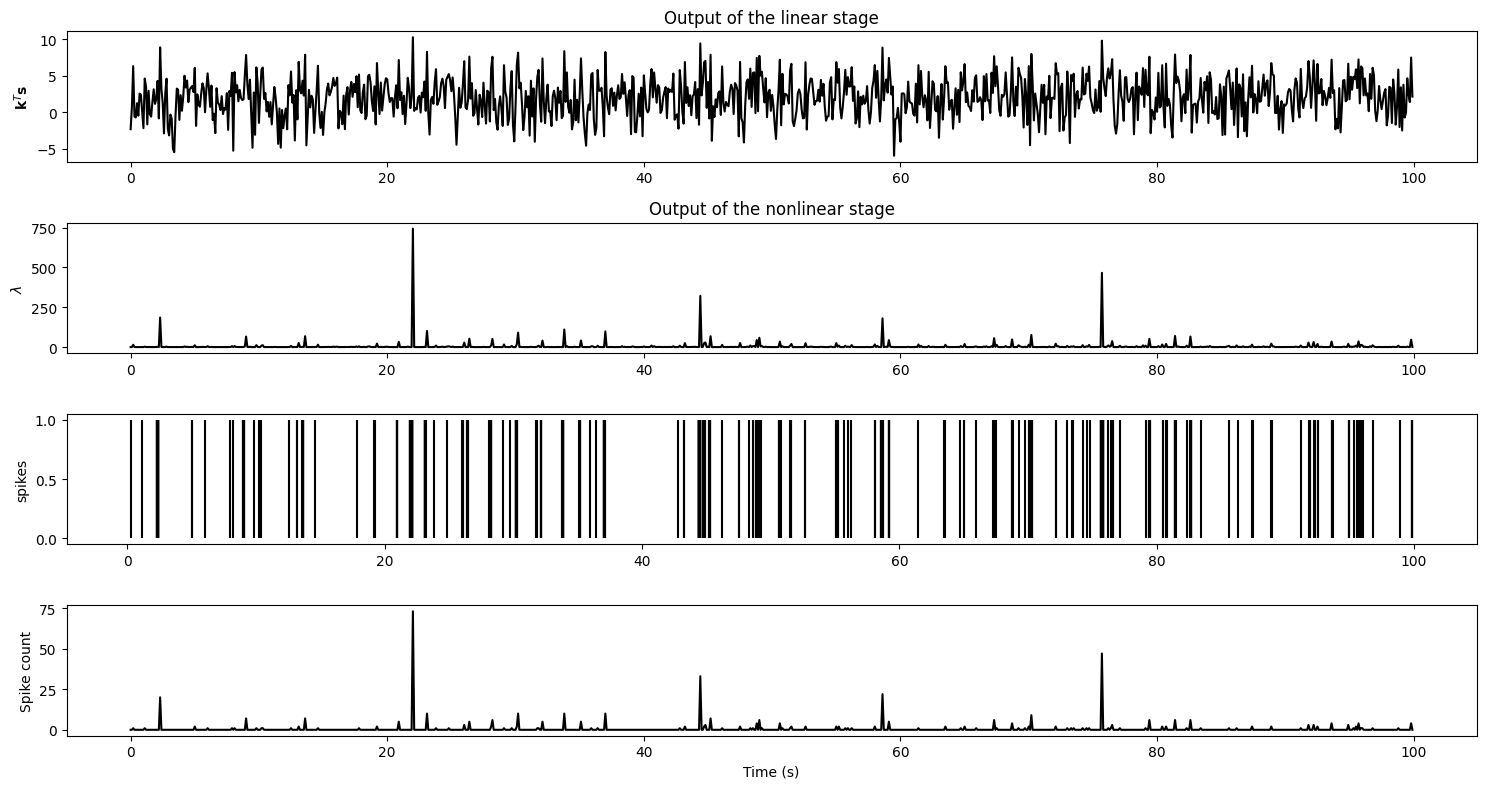

Text(0, 0.5, 'f($\\mathbf{k}^T \\mathbf{s})$')

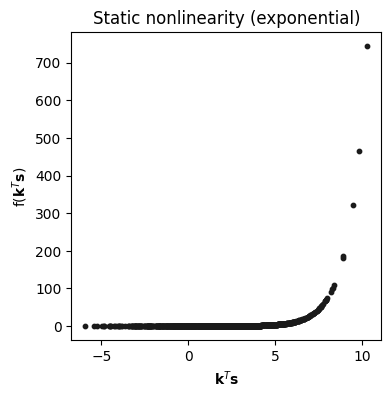

In [10]:
plt.figure(figsize=(15, 8))

n_bins = lamba.shape[0]
t = np.arange(n_bins) * dt

plt.subplot(4,1,1)
plt.title('Output of the linear stage')
plt.plot(t, ks, 'k')
plt.ylabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.tight_layout()

plt.subplot(4,1,2)
plt.title('Output of the nonlinear stage')
plt.plot(t, lamba,'k')
plt.ylabel(r'$\lambda$')
plt.tight_layout()

plt.subplot(4,1,3)
plt.vlines(spike_times, 0, 1, 'k')
plt.ylabel('spikes')
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(t, spike_counts, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Spike count')
plt.tight_layout()
plt.show()

# Relationship between input and output
plt.figure(figsize=(4,4))
plt.title('Static nonlinearity (exponential)')
plt.scatter(ks, lamba, s = 10, c = [3 * [.1]])
plt.xlabel(r'$\mathbf{k}^T \mathbf{s}$')
plt.ylabel(r'f($\mathbf{k}^T \mathbf{s})$')


**FITTING THE LINEAR-NONLINEAR POISSON GLM**

*Now, we study the reverse problem. Suppose we have the neuron's response and we know what stimulus it has been given, the goal is to determine what is the neuron's receptive field/filter $K$. For that, we need to derive the maximum likelihood estimator for $\bm{k}$*

The likelihood of a neuron's response $r_t$ at time instant $t$ is given by the Poisson p.d.f. Because we assumed that spike times are independent from one another, the probability of the neuron's response for the whole spike sequence is simply

$$P(R|\lambda) = \prod_{t=1}^N P(r_t|\lambda_t)$$

As usual, we work with log-likelihood which yields 

$$log\ P(R|\lambda) = \sum_{t=1}^N log\ P(r_t|\lambda_t) = \sum_{t=1}^N (r_t\log \lambda_t + r_t\log \Delta - \log r_t! - \lambda_t \Delta) $$

Only the $\lambda_t$ term has dependence on $\bm{k}$ so upon differentiation all other terms will yield zero and recal we are interested in the maximum of the log likelihood which is the same as the minimum of minus the log likelihood, meaning we can write

$$-log\ P(R|\lambda) = \sum_{t=1}^N (r_t\log \lambda_t - \lambda_t \Delta) =  -\sum_{t=1}^N r_t (\bm{k}\cdot\bm{s}_t) +  \Delta\sum_{t=1}^N  e^{(\bm{k}\cdot\bm{s}_t)}$$

The maximum likelihood estimator $\hat{\bm{k}}$ is given by taking the derivative of $log\ P(R|\lambda)$ w.r.t. $\bm{k}$ which gives

$$\frac{\partial{\log P}}{\partial{\bm{k}}} = \frac{\partial }{\partial\bm{k}} \left[\sum_{t=1}^N (r_t (\bm{k}\cdot\bm{s}_t) - e^{(\bm{k}\cdot\bm{s}_t)} \Delta)\right] = -\sum_t r_t s_t + \Delta\sum_t s_t\ e^{(\bm{k}\cdot\bm{s}_t)}$$

Let's fit the linear-nonlinear model. For the exponential nonlinearity, the log-likelihood is a concave function and therefore the parameters can be found using gradient descent to look for the configuration of the parameters that *minimize the negative of the log-likelihood* (same as maximizing the log-likelihood). The scipy package provides the minimize function that can be used to this purpose. The minimize function supports a number of algorithms. As we can explicitly compute the gradient for this type of linear-nonlinear poisson model, algorithms that make use of the gradient are prefered.

We will initialize the RF parameters using the spike-triggered average (STA), $k_{STA} = \frac{\bm{S}^T\bm{r}}{n_{spikes}}$, where $n_{spikes}$ is the total number of spikes in $\bm{r}$.

**Note:** the exponential nonlinearity is very sensitive to the scaling. To avoid numerical issues we initialize the RF parameters with $\mathbf{k}_\mathrm{init} = \frac{\mathbf{k}_\mathrm{STA}}{10}$.

In [11]:
from scipy.optimize import minimize
# Getting some data analysis flashbacks...

# Define the function for minimisation
def n_loglikelihood(k, spike_counts, S):
    r = spike_counts 
    ks = k @ S.T
    lamba = np.exp(ks)
    return - r @ ks + dt * np.sum(lamba) 

def grad(k, spike_counts, S):
    # Expression for the gradient of the negative log likelihood,
    # though others from the scipy.minimize method could be used
    r = spike_counts
    lamba = np.exp(k @ S.T)
    return - S.T @ r + dt*(S.T @ lamba)

       
k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
res = minimize(fun = n_loglikelihood, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
K_est = res.x

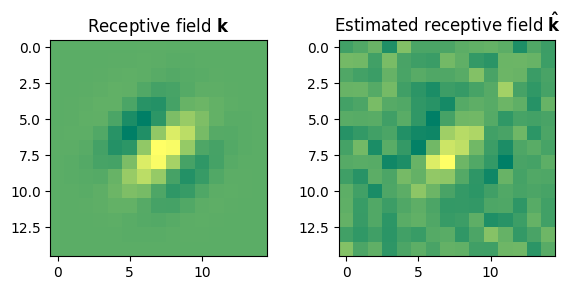

In [12]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title(r'Receptive field $\mathbf{k}$')
plt.imshow(K, cmap='summer')
plt.tight_layout()

plt.subplot(1,2,2)
plt.title(r'Estimated receptive field $\mathbf{\hat{k}}$')
plt.imshow(K_est[:-1].reshape(15, 15),cmap='summer') 
plt.tight_layout()

### <font color='teal'> Regularization </font>

As you can see from the plots above, the fitting procedure we use tends to overestimate the contribution of small values of $\bm{k}$. This is evident from the pixel values of the estimation near the borders of the receptive field.

This can be prevented by adding a regularization term to our cost function (mean square error): This can be done in a wide variety of ways, we'll show two.

In **L1 regularization** we add a term to the cost function that is proportional to the sum of the absolute values of the parameters of the model:

$$r = \alpha\sum_{k\in \bm{k}}|k|$$

This term penalizes too large values of $k$ and promotes *sparsity*, that is, only a subset of the parameters will give a significant contribution.

In **L2 regularization** we add a term to the cost function that is proportional to the sum of the squares of the parameters of the model

$$r = \alpha\sum_{k\in \bm{k}}k^2$$

This term also penalizes too large values of $k$.

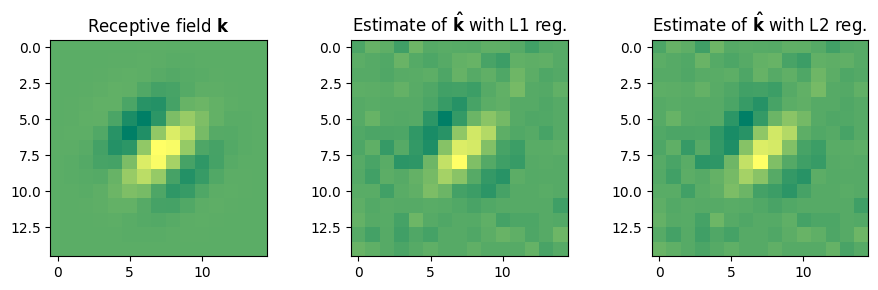

In [16]:
# Adding regularization
def nll_l1(k, spike_counts, S, alpha):
    r = spike_counts 
    ks = k @ S.T
    lamba = np.exp(ks)

    L1 = alpha * np.sum(np.abs(k))
    
    return - r @ ks + dt * np.sum(lamba) + L1

def nll_l2(k, spike_counts, S, alpha):
    r = spike_counts 
    ks = k @ S.T
    lamba = np.exp(ks)

    L2 = alpha * np.sum(np.abs(k))
    
    return - r @ ks + dt * np.sum(lamba) + L2

# Results
res_l1 = minimize(fun = nll_l1, x0 = k_STA / 10, args = (spike_counts, S_flat, 1))
K_est_l1 = res_l1.x

res_l2 = minimize(fun = nll_l2, x0 = k_STA / 10, args = (spike_counts, S_flat, 1))
K_est_l2 = res_l2.x

# Plot results
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title(r'Receptive field $\mathbf{k}$')
plt.imshow(K, cmap='summer')
plt.tight_layout()

plt.subplot(1,3,2)
plt.title(r'Estimate of $\mathbf{\hat{k}}$ with L1 reg.')
plt.imshow(K_est_l1[:-1].reshape(15, 15), cmap='summer') 
plt.tight_layout()

plt.subplot(1,3,3)
plt.title(r'Estimate of $\mathbf{\hat{k}}$ with L2 reg.')
plt.imshow(K_est_l2[:-1].reshape(15, 15), cmap='summer') 
plt.tight_layout()

The regularization does indeed lower the filter values closer to the border, though it is still not perfect and takes longer. Perhaps increasing $\alpha$ can improve the result further.

## KEY POINTS

- GLMs are statistical models of neural responses
- GLMs consist of a linear filter and a static non-linearity
- GLMs' receptive fields show to which part of the stimulus space a neuron responds preferentially